In [2]:
import sys
import jax.numpy as jnp
import numpy as np
from trax import layers as tl
from trax.shapes import signature
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape

sys.path.insert(0, "../..")
from src.models.build import summary
from pathlib import Path
from src.data import data_tools


In [13]:
url = "https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip"
data_dir = Path("../../data/raw/")

data_tools.get_file(data_dir, "faces.zip", url)

100%|██████████| 3.80M/3.80M [00:00<00:00, 6.37MiB/s]


In [29]:
from src.data import data_tools

paths, _ = data_tools.iter_valid_paths(
    data_dir / "data/faces/training/", formats=[".pgm"]
)


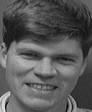

In [55]:
file = next(paths)
from PIL import Image

img = Image.open(file)
img


In [69]:
import numpy as np

rng = np.random.default_rng()
X = rng.random((32,) + np.array(img).shape + (1,))
X.shape


(32, 112, 92, 1)

In [136]:
def Avg2D():
    return tl.Fn("Avg2D", lambda x: x.mean(axis=(1, 2)), n_out=1)


In [138]:
@assert_shape('bwhc->bd')
def Encoder(config) -> cb.Serial:
    model = cb.Serial(
        tl.Conv(config["filters1"], kernel_size=(3, 3), strides=(3, 3)),
        tl.Relu(),
        tl.Conv(config["filters2"], kernel_size=(3, 3), strides=(2, 2)),
        tl.Relu(),
        tl.Conv(config["filters3"], kernel_size=(3, 3), strides=(2, 2)),
        tl.Relu(),
        Avg2D(),
    )
    return model


config = {
    "filters1": 96,
    "filters2": 256,
    "filters3": 384,
}
encoder = Encoder(config)
encoder.init_weights_and_state(signature(X))
summary(encoder, X)


layer                   input                dtype     output               dtype 
(0) Conv                (32, 112, 92, 1)   (float64) | (32, 37, 30, 96)   (float32)
(1) Relu                (32, 37, 30, 96)   (float32) | (32, 37, 30, 96)   (float32)
(2) Conv                (32, 37, 30, 96)   (float32) | (32, 18, 14, 256)  (float32)
(3) Relu                (32, 18, 14, 256)  (float32) | (32, 18, 14, 256)  (float32)
(4) Conv                (32, 18, 14, 256)  (float32) | (32, 8, 6, 384)    (float32)
(5) Relu                (32, 8, 6, 384)    (float32) | (32, 8, 6, 384)    (float32)
(6) Avg2D               (32, 8, 6, 384)    (float32) | (32, 384)          (float32)


ShapeDtype{shape:(32, 384), dtype:float32}

In [139]:
x1 = rng.random((32, 8))
x2 = rng.random((32, 8))
yhat = rng.integers(0, 2, 32)
np.linalg.norm(x1 - x2, axis=-1)


array([1.06323986, 0.80185963, 0.97461545, 0.90348607, 1.00795089,
       1.09119619, 1.09871483, 1.35661994, 0.89394497, 0.99746945,
       1.18472159, 0.59169836, 0.90698596, 1.10514335, 1.40214996,
       0.81984001, 0.88808493, 0.79970648, 0.94182016, 1.02701846,
       0.69856776, 1.4105474 , 0.98327833, 1.09168267, 1.2169808 ,
       0.9075846 , 1.26023062, 0.99176536, 1.34564714, 1.22965689,
       0.87278832, 1.10909032])

In [140]:
class ContrastiveLoss:
    def __init__(self, margin: float = 1.0):
        self.margin = margin

    def __repr__(self) -> str:
        return "ContrastiveLoss"

    def __call__(self, y1, y2, yhat):
        distance = jnp.linalg.norm(y1 - y2, axis=-1)
        distance_ = jnp.clip(distance, 1e-14, 10)
        return jnp.mean(
            yhat * distance + (1 - yhat) * jnp.maximum(0, self.margin - distance)
        )


loss = ContrastiveLoss()
loss(x1, x2, yhat)


DeviceArray(0.59690595, dtype=float32)

In [141]:
def Siamese(config):
    encoder = Encoder(config)
    model = cb.Parallel(encoder, encoder)
    return model


In [144]:
X1 = rng.random((32,) + np.array(img).shape + (1,))
X2 = rng.random((32,) + np.array(img).shape + (1,))
siamese = Siamese(config)
siamese.init_weights_and_state(signature((X1, X2)))
yhat = siamese((X1, X2))
signature(yhat)


(ShapeDtype{shape:(32, 384), dtype:float32},
 ShapeDtype{shape:(32, 384), dtype:float32})

In [145]:
siamese


Parallel_in2_out2[
  Serial[
    Conv
    Serial[
      Relu
    ]
    Conv
    Serial[
      Relu
    ]
    Conv
    Serial[
      Relu
    ]
    Avg2D
  ]
  Serial[
    Conv
    Serial[
      Relu
    ]
    Conv
    Serial[
      Relu
    ]
    Conv
    Serial[
      Relu
    ]
    Avg2D
  ]
]